In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(sys.path)

%reload_ext autoreload
%autoreload 2

['/Users/ben/Documents/work/research projects/code/hdiva', '/Users/ben/.pyenv/versions/3.10.18/lib/python310.zip', '/Users/ben/.pyenv/versions/3.10.18/lib/python3.10', '/Users/ben/.pyenv/versions/3.10.18/lib/python3.10/lib-dynload', '', '/Users/ben/.pyenv/versions/pyenv-310/lib/python3.10/site-packages']


# VAE

In [142]:
from b_models.vae import VariableConvEncoder, VariableConvDecoder, VAE

num_channels = 1
image_dims = 32
latent_dims = 5

enc = VariableConvEncoder(
    num_channels,
    image_dims,
    latent_dims, 
    channels=[32, 32, 32, 32], 
    bias=True,
)

dec = VariableConvDecoder(
    num_channels,
    image_dims,
    latent_dims,
    channels=[32, 32, 32, 32],  # output_channels, kernel_size, stride, padding
    output_channels=1,
    bias=True,
)

vae = VAE(
    encoder=enc,
    decoder=dec,
    kl_reduction="mean"
)

In [143]:
# count number of parameters in vae
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"Number of parameters in VAE: {num_params}")

Number of parameters in VAE: 79883


In [136]:
example_image = torch.randn(1, num_channels, image_dims, image_dims)
# normalize the image to (-1, 1)
example_image = example_image * 2 - 1

vae(example_image)[0].shape

torch.Size([1, 1, 32, 32])

now train the model on the dataset

In [103]:
from utils.disks import random_two_disk_dataset
# random sample of disks
data = random_two_disk_dataset(
    delta_id=.2,
    d=10, outer_radius=4, transition_width=2,
    img_size=32, num_imgs=5e4,
    ib=0.2
)[0]

In [115]:
from utils.disks import DiskDataset
from torch.utils.data import DataLoader
dataset = DiskDataset(data)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [144]:
# now train model
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

vae.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=3e-4)
criterion = nn.MSELoss()
n_epochs = 50

# kl annealing schedule
kl_weight = 0.0
def kl_annealing(epoch, n_epochs_anneal, schedule='linear'):
    if schedule == 'linear':
        if epoch < n_epochs_anneal:
            kl_weight = epoch / n_epochs_anneal
        else:
            kl_weight = 1.0
    elif schedule == 'cosine':
        if epoch < n_epochs_anneal:
            # cosine annealing from 0 to 1
            kl_weight = 1- 0.5 * (1 + np.cos(np.pi * epoch / n_epochs_anneal))
        else:
            kl_weight = 1.0
    return kl_weight

for epoch in tqdm(range(n_epochs)):
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = vae(batch)[0]
        mse_loss = criterion(output, batch)
        kl_weight = kl_annealing(epoch, 20, schedule='cosine')
        # kl_weight = 1
        kl_loss = vae.kl
        # Combine losses
        loss = mse_loss + kl_loss * kl_weight
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, MSE Loss: {mse_loss.item():.4f}, KL weight: {kl_weight:.4f}, KL Loss: {kl_loss.item():.4f}")

  2%|▏         | 1/50 [00:19<15:34, 19.07s/it]

Epoch 1, Loss: 0.0210, MSE Loss: 0.0210, KL weight: 0.0000, KL Loss: 75.5332


  4%|▍         | 2/50 [00:37<15:00, 18.76s/it]

Epoch 2, Loss: 0.0245, MSE Loss: 0.0245, KL weight: 0.0062, KL Loss: 0.0033


  6%|▌         | 3/50 [00:55<14:32, 18.56s/it]

Epoch 3, Loss: 0.0225, MSE Loss: 0.0225, KL weight: 0.0245, KL Loss: 0.0001


  8%|▊         | 4/50 [01:14<14:09, 18.47s/it]

Epoch 4, Loss: 0.0219, MSE Loss: 0.0219, KL weight: 0.0545, KL Loss: 0.0000


 10%|█         | 5/50 [01:32<13:48, 18.41s/it]

Epoch 5, Loss: 0.0192, MSE Loss: 0.0192, KL weight: 0.0955, KL Loss: 0.0000


 12%|█▏        | 6/50 [01:50<13:26, 18.32s/it]

Epoch 6, Loss: 0.0209, MSE Loss: 0.0209, KL weight: 0.1464, KL Loss: 0.0000


 14%|█▍        | 7/50 [02:09<13:08, 18.34s/it]

Epoch 7, Loss: 0.0210, MSE Loss: 0.0210, KL weight: 0.2061, KL Loss: 0.0000


 16%|█▌        | 8/50 [02:27<12:47, 18.28s/it]

Epoch 8, Loss: 0.0225, MSE Loss: 0.0225, KL weight: 0.2730, KL Loss: 0.0000


 18%|█▊        | 9/50 [02:45<12:30, 18.30s/it]

Epoch 9, Loss: 0.0237, MSE Loss: 0.0237, KL weight: 0.3455, KL Loss: 0.0000


 20%|██        | 10/50 [03:03<12:11, 18.28s/it]

Epoch 10, Loss: 0.0209, MSE Loss: 0.0209, KL weight: 0.4218, KL Loss: 0.0000


 22%|██▏       | 11/50 [03:22<11:54, 18.33s/it]

Epoch 11, Loss: 0.0217, MSE Loss: 0.0217, KL weight: 0.5000, KL Loss: 0.0000


 24%|██▍       | 12/50 [03:40<11:37, 18.35s/it]

Epoch 12, Loss: 0.0224, MSE Loss: 0.0224, KL weight: 0.5782, KL Loss: 0.0000


 26%|██▌       | 13/50 [03:59<11:23, 18.46s/it]

Epoch 13, Loss: 0.0222, MSE Loss: 0.0222, KL weight: 0.6545, KL Loss: 0.0000


 28%|██▊       | 14/50 [04:17<11:05, 18.50s/it]

Epoch 14, Loss: 0.0210, MSE Loss: 0.0210, KL weight: 0.7270, KL Loss: 0.0000


 30%|███       | 15/50 [04:36<10:48, 18.52s/it]

Epoch 15, Loss: 0.0262, MSE Loss: 0.0262, KL weight: 0.7939, KL Loss: 0.0000


 32%|███▏      | 16/50 [04:55<10:34, 18.67s/it]

Epoch 16, Loss: 0.0202, MSE Loss: 0.0202, KL weight: 0.8536, KL Loss: 0.0000


 34%|███▍      | 17/50 [05:14<10:17, 18.71s/it]

Epoch 17, Loss: 0.0240, MSE Loss: 0.0240, KL weight: 0.9045, KL Loss: 0.0000


 36%|███▌      | 18/50 [05:33<10:03, 18.86s/it]

Epoch 18, Loss: 0.0218, MSE Loss: 0.0218, KL weight: 0.9455, KL Loss: 0.0000


 38%|███▊      | 19/50 [05:52<09:48, 19.00s/it]

Epoch 19, Loss: 0.0242, MSE Loss: 0.0241, KL weight: 0.9755, KL Loss: 0.0000


 40%|████      | 20/50 [06:11<09:29, 18.99s/it]

Epoch 20, Loss: 0.0226, MSE Loss: 0.0226, KL weight: 0.9938, KL Loss: 0.0000


 42%|████▏     | 21/50 [06:31<09:14, 19.12s/it]

Epoch 21, Loss: 0.0215, MSE Loss: 0.0215, KL weight: 1.0000, KL Loss: 0.0000


 44%|████▍     | 22/50 [06:50<08:55, 19.12s/it]

Epoch 22, Loss: 0.0237, MSE Loss: 0.0237, KL weight: 1.0000, KL Loss: 0.0000


 46%|████▌     | 23/50 [07:10<08:42, 19.35s/it]

Epoch 23, Loss: 0.0205, MSE Loss: 0.0205, KL weight: 1.0000, KL Loss: 0.0000


 48%|████▊     | 24/50 [07:29<08:25, 19.45s/it]

Epoch 24, Loss: 0.0242, MSE Loss: 0.0242, KL weight: 1.0000, KL Loss: 0.0000


 50%|█████     | 25/50 [07:49<08:04, 19.36s/it]

Epoch 25, Loss: 0.0258, MSE Loss: 0.0258, KL weight: 1.0000, KL Loss: 0.0000


 52%|█████▏    | 26/50 [08:09<07:49, 19.56s/it]

Epoch 26, Loss: 0.0266, MSE Loss: 0.0266, KL weight: 1.0000, KL Loss: 0.0000


 54%|█████▍    | 27/50 [08:27<07:23, 19.27s/it]

Epoch 27, Loss: 0.0210, MSE Loss: 0.0210, KL weight: 1.0000, KL Loss: 0.0000


 56%|█████▌    | 28/50 [08:46<06:59, 19.08s/it]

Epoch 28, Loss: 0.0227, MSE Loss: 0.0227, KL weight: 1.0000, KL Loss: 0.0000


 58%|█████▊    | 29/50 [09:05<06:38, 18.99s/it]

Epoch 29, Loss: 0.0218, MSE Loss: 0.0218, KL weight: 1.0000, KL Loss: 0.0000


 60%|██████    | 30/50 [09:25<06:25, 19.28s/it]

Epoch 30, Loss: 0.0204, MSE Loss: 0.0204, KL weight: 1.0000, KL Loss: 0.0000


 62%|██████▏   | 31/50 [09:44<06:06, 19.31s/it]

Epoch 31, Loss: 0.0224, MSE Loss: 0.0224, KL weight: 1.0000, KL Loss: 0.0000


 64%|██████▍   | 32/50 [10:04<05:52, 19.56s/it]

Epoch 32, Loss: 0.0222, MSE Loss: 0.0222, KL weight: 1.0000, KL Loss: 0.0000


 66%|██████▌   | 33/50 [10:27<05:50, 20.59s/it]

Epoch 33, Loss: 0.0193, MSE Loss: 0.0193, KL weight: 1.0000, KL Loss: 0.0000


 68%|██████▊   | 34/50 [10:50<05:42, 21.39s/it]

Epoch 34, Loss: 0.0213, MSE Loss: 0.0213, KL weight: 1.0000, KL Loss: 0.0000


 70%|███████   | 35/50 [11:15<05:37, 22.47s/it]

Epoch 35, Loss: 0.0204, MSE Loss: 0.0204, KL weight: 1.0000, KL Loss: 0.0000


 72%|███████▏  | 36/50 [11:39<05:20, 22.88s/it]

Epoch 36, Loss: 0.0186, MSE Loss: 0.0186, KL weight: 1.0000, KL Loss: 0.0000


 74%|███████▍  | 37/50 [12:04<05:04, 23.45s/it]

Epoch 37, Loss: 0.0196, MSE Loss: 0.0196, KL weight: 1.0000, KL Loss: 0.0000


 76%|███████▌  | 38/50 [12:28<04:43, 23.60s/it]

Epoch 38, Loss: 0.0237, MSE Loss: 0.0237, KL weight: 1.0000, KL Loss: 0.0000


 78%|███████▊  | 39/50 [12:53<04:23, 23.93s/it]

Epoch 39, Loss: 0.0206, MSE Loss: 0.0206, KL weight: 1.0000, KL Loss: 0.0000


 80%|████████  | 40/50 [13:17<03:59, 23.99s/it]

Epoch 40, Loss: 0.0211, MSE Loss: 0.0211, KL weight: 1.0000, KL Loss: 0.0000


 82%|████████▏ | 41/50 [13:44<03:43, 24.82s/it]

Epoch 41, Loss: 0.0223, MSE Loss: 0.0223, KL weight: 1.0000, KL Loss: 0.0000


 84%|████████▍ | 42/50 [14:08<03:18, 24.83s/it]

Epoch 42, Loss: 0.0245, MSE Loss: 0.0245, KL weight: 1.0000, KL Loss: 0.0000


 86%|████████▌ | 43/50 [14:33<02:54, 24.90s/it]

Epoch 43, Loss: 0.0233, MSE Loss: 0.0233, KL weight: 1.0000, KL Loss: 0.0000


 88%|████████▊ | 44/50 [14:59<02:29, 24.97s/it]

Epoch 44, Loss: 0.0262, MSE Loss: 0.0262, KL weight: 1.0000, KL Loss: 0.0000


 90%|█████████ | 45/50 [15:24<02:04, 24.98s/it]

Epoch 45, Loss: 0.0251, MSE Loss: 0.0251, KL weight: 1.0000, KL Loss: 0.0000


 92%|█████████▏| 46/50 [15:48<01:39, 24.93s/it]

Epoch 46, Loss: 0.0233, MSE Loss: 0.0233, KL weight: 1.0000, KL Loss: 0.0000


 94%|█████████▍| 47/50 [16:14<01:15, 25.12s/it]

Epoch 47, Loss: 0.0226, MSE Loss: 0.0226, KL weight: 1.0000, KL Loss: 0.0000


 96%|█████████▌| 48/50 [16:37<00:48, 24.34s/it]

Epoch 48, Loss: 0.0236, MSE Loss: 0.0236, KL weight: 1.0000, KL Loss: 0.0000


 98%|█████████▊| 49/50 [16:58<00:23, 23.52s/it]

Epoch 49, Loss: 0.0250, MSE Loss: 0.0250, KL weight: 1.0000, KL Loss: 0.0000


100%|██████████| 50/50 [17:20<00:00, 20.81s/it]

Epoch 50, Loss: 0.0236, MSE Loss: 0.0236, KL weight: 1.0000, KL Loss: 0.0000


Test Loss: 0.0377


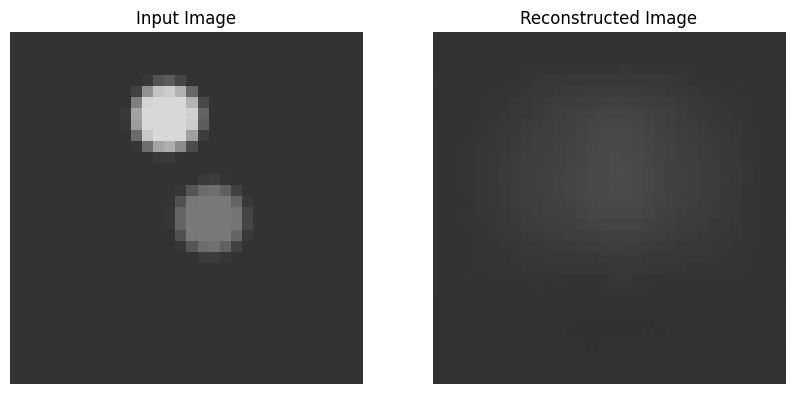

In [145]:
from utils.base_utils import to_01, to_0c
test_img = data[12].unsqueeze(0)

vae.eval()
output = vae(test_img)[0].detach()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_img.squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(to_01(output).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Reconstructed Image")
ax[1].axis("off")

test_loss = criterion(to_0c(test_img), output).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0242


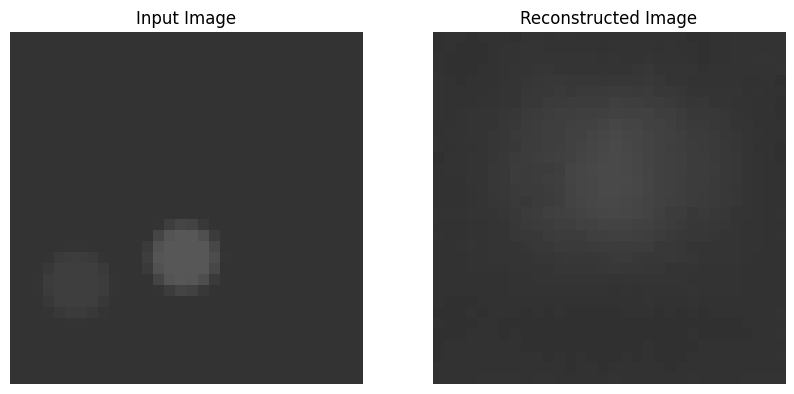

In [129]:
from utils.base_utils import to_01, to_0c
test_img = data[0:128]

output = vae(test_img)[0].detach()
output = to_01(output)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_img[0].squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(output[0].squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Reconstructed Image")
ax[1].axis("off")

test_loss = criterion(to_0c(test_img), to_0c(output)).item()
print(f"Test Loss: {test_loss:.4f}")

# hVAE

In [ ]:
# let's try to implement a hVAE

 

# hierarchical dataset